In [1]:
import os
import numpy as np
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import OrderedDict
from torchsummary import summary

%matplotlib inline

# check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("We use " + DEVICE)
torch.cuda.empty_cache()

We use cuda


In [2]:
batch_size = 32
learning_rate  = 1e-2
momentum = 0.7
weight_decay = 0.01
epochs = 100
patience = 7

In [3]:
transform = transforms.Compose([
                               transforms.Resize([256, 256]),
                               transforms.RandomCrop(224),
                               transforms.RandomHorizontalFlip(),
                               transforms.RandomVerticalFlip(),
                               transforms.RandomRotation(15),
                               transforms.ToTensor(),
                               transforms.Normalize(
                                   (0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
                               ])

train_db = datasets.CIFAR10('datasets/cifar10',
                            train=True,
                            download=True,
                            transform=transform,
                            )

test_db = datasets.CIFAR10('datasets/cifar10',
                           train=False,
                           download=True,
                           transform=transform,
                           )

print('train:', len(train_db), 'test:', len(test_db))

Files already downloaded and verified
Files already downloaded and verified
train: 50000 test: 10000


In [4]:
train_db, val_db = torch.utils.data.random_split(train_db, [40000, 10000])

print('train:', len(train_db), 'validation:', len(val_db))

train: 40000 validation: 10000


In [5]:
# number of workers
nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])
print('Using {} dataloader workers every process'.format(nw))
train_loader = DataLoader(
    train_db,
    batch_size=batch_size,
    drop_last=True,
    shuffle=True,
    num_workers=nw,
)

val_loader = DataLoader(
    val_db,
    batch_size=batch_size,
    drop_last=True,
    shuffle=False,
    num_workers=nw,
)

test_loader = DataLoader(
    test_db,
    batch_size=batch_size,
    drop_last=True,
    shuffle=False,
    num_workers=nw,
)

Using 8 dataloader workers every process


In [6]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""

    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(
                f'EarlyStopping counter: {self.counter} out of {self.patience}\n')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(
                f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...\n')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [7]:
class VGG(nn.Module):
    def __init__(self, cfg, num_classes=10, init_weights=False):
        super(VGG, self).__init__()
        self.cfg = cfg
        self.num_classes = num_classes
        self.features = make_features(self.cfg)
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(512*7*7, 2048),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(2048, 2048),
            nn.ReLU(True),
            nn.Linear(2048, self.num_classes)
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        # N x 3 x 224 x 224
        x = self.features(x)
        # N x 512 x 7 x 7
        x = torch.flatten(x, start_dim=1)
        # N x 512*7*7
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                # nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


def make_features(cfg: list):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == "M":
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels=in_channels, out_channels=v, kernel_size=3, stride=1, padding=1)
            batchnorm2d = nn.BatchNorm2d(v)
            layers += [conv2d, batchnorm2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


In [8]:
cfgs = {
    'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

def vgg(model_name="vgg16", **kwargs):
    try:
        cfg = cfgs[model_name]
    except:
        print("Warning: model number {} not in cfgs dict!".format(model_name))
        exit(-1)
    model = VGG(cfg, **kwargs)
    return model

In [9]:
net = vgg().to(DEVICE)
# net = models.vgg16().to(DEVICE)
criteon = nn.CrossEntropyLoss().to(DEVICE)
optimizer = optim.SGD(net.parameters(),
                      lr=learning_rate,
                      momentum=momentum,
                      weight_decay = weight_decay,
                      )

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 'min', min_lr=1e-4, factor=0.1, patience=3)

In [10]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [11]:
summary(net, (3, 224, 224))
print(f'parameters_count: {count_parameters(net)}')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
         MaxPool2d-7         [-1, 64, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]          73,856
       BatchNorm2d-9        [-1, 128, 112, 112]             256
             ReLU-10        [-1, 128, 112, 112]               0
           Conv2d-11        [-1, 128, 112, 112]         147,584
      BatchNorm2d-12        [-1, 128, 112, 112]             256
             ReLU-13        [-1, 128, 112, 112]               0
        MaxPool2d-14          [-1, 128,

In [12]:
def train(epoch):
    train_loss = 0
    train_acc = 0
    train_correct = 0
    net.train()
    for batch_idx, (data, label) in enumerate(train_loader):
        data, label = data.to(DEVICE), label.to(DEVICE)

        logits = net(data)
        loss = criteon(logits, label)
        train_loss += loss.item()
        
        pred = torch.argmax(logits, dim=1)
        train_correct += torch.eq(pred, label).float().sum().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch + 1, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    
    train_loss /= len(train_loader.dataset)
    train_acc = 1. * train_correct / len(train_loader.dataset)

    return train_loss, train_acc

In [13]:
def validate():
    val_loss = 0
    val_acc = 0
    val_correct = 0
    net.eval()
    with torch.no_grad():
        for data, label in val_loader:
            data, label = data.to(DEVICE), label.to(DEVICE)

            logits = net(data)
            val_loss += criteon(logits, label).item()

            pred = torch.argmax(logits, dim=1)
            val_correct += torch.eq(pred, label).float().sum().item()
            

    val_loss /= len(val_loader.dataset)
    val_acc = 1. * val_correct / len(val_loader.dataset)

    print('VAL set: Average loss: {:.6f}, Accuracy: {}/{} ({:.1f}%)'.format(
        val_loss, val_correct, len(val_loader.dataset), 100. * val_acc))
    
    return val_loss, val_acc

In [14]:
def test():
    test_loss = 0
    test_acc = 0
    test_correct = 0
    net.eval()
    with torch.no_grad():
        for data, label in test_loader:
            data, label = data.to(DEVICE), label.to(DEVICE)

            logits = net(data)
            test_loss += criteon(logits, label).item()

            pred = torch.argmax(logits, dim=1)
            test_correct += torch.eq(pred, label).float().sum().item()

    test_loss /= len(test_loader.dataset)
    test_acc = 1. * test_correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, test_correct, len(test_loader.dataset), 100. * test_acc))

In [15]:
def plot_loss(train_losses, valid_losses):
    plt.style.use('seaborn')
    fig, ax = plt.subplots(figsize=(8, 4.5))
    
    # find position of lowest validation loss
    minpos = valid_losses.index(min(valid_losses))

    train_losses = np.array(train_losses)
    valid_losses = np.array(valid_losses)

    ax.plot(train_losses, color='blue', label='Training loss')
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs",
           xlabel='Epoch',
           ylabel='Loss')
    
    plt.axvline(minpos, linestyle='--', color='r',
                label='Early Stopping Checkpoint')
    ax.legend()

    # change the plot style to default
    plt.style.use('default')

In [16]:
def plot_acc(train_accuracies, validate_accuracies):
    plt.style.use('seaborn')
    fig, ax = plt.subplots(figsize=(8, 4.5))

    # find position of lowest validation loss
    maxpos = validate_accuracies.index(max(validate_accuracies))
    
    train_accuracies = np.array(train_accuracies)
    validate_accuracies = np.array(validate_accuracies)
    
    ax.plot(train_accuracies, color='blue', label='Training accuracy')
    ax.plot(validate_accuracies, color='red', label='Validation accuracy')
    ax.set(title="Accuracy over epochs",
           xlabel='Epoch',
           ylabel='Accuracy')
    
    plt.axvline(maxpos, linestyle='--', color='r',
                label='Early Stopping Checkpoint')
    ax.legend()

    # change the plot style to default
    plt.style.use('default')

In [17]:
def main():
    train_losses = []
    validate_losses = []
    train_accuracies = []
    validate_accuracies = []
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    for epoch in range(epochs):
        train_loss, train_accuracy = train(epoch)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        validate_loss, validate_accuracy = validate()
        validate_losses.append(validate_loss)
        validate_accuracies.append(validate_accuracy)
        scheduler.step(validate_loss)
        early_stopping(val_loss=validate_loss, model=net)
        
        if early_stopping.early_stop:
            print("\nEarly stopping\n")
            break

    plot_loss(train_losses, validate_losses)
    plot_acc(train_accuracies, validate_accuracies)
    
    # load the last checkpoint with the best model
    net.load_state_dict(torch.load('checkpoint.pt'))

    test()

Train Epoch: 1 [0/40000 (0%)]	Loss: 2.299644
Train Epoch: 1 [3200/40000 (8%)]	Loss: 2.184876
Train Epoch: 1 [6400/40000 (16%)]	Loss: 2.325902
Train Epoch: 1 [9600/40000 (24%)]	Loss: 1.941452
Train Epoch: 1 [12800/40000 (32%)]	Loss: 1.621699
Train Epoch: 1 [16000/40000 (40%)]	Loss: 1.575210
Train Epoch: 1 [19200/40000 (48%)]	Loss: 1.416985
Train Epoch: 1 [22400/40000 (56%)]	Loss: 1.944646
Train Epoch: 1 [25600/40000 (64%)]	Loss: 1.557973
Train Epoch: 1 [28800/40000 (72%)]	Loss: 1.400969
Train Epoch: 1 [32000/40000 (80%)]	Loss: 1.681613
Train Epoch: 1 [35200/40000 (88%)]	Loss: 1.285379
Train Epoch: 1 [38400/40000 (96%)]	Loss: 1.263976
VAL set: Average loss: 0.046813, Accuracy: 4561.0/10000 (45.6%)
Validation loss decreased (inf --> 0.046813).  Saving model ...

Train Epoch: 2 [0/40000 (0%)]	Loss: 1.794899
Train Epoch: 2 [3200/40000 (8%)]	Loss: 1.459806
Train Epoch: 2 [6400/40000 (16%)]	Loss: 1.552803
Train Epoch: 2 [9600/40000 (24%)]	Loss: 1.576160
Train Epoch: 2 [12800/40000 (32%)]	Loss

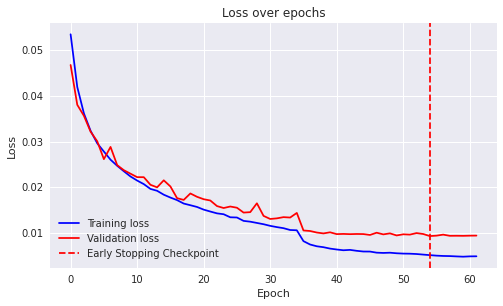

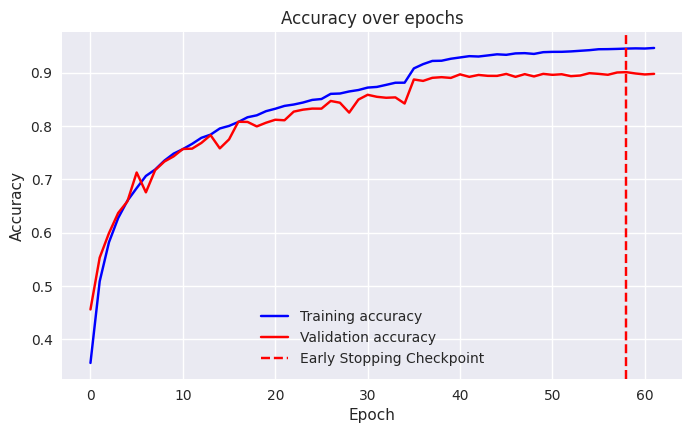

In [18]:
%%time
if __name__ == '__main__':
    main()

Text(0.5, 0.98, 'vgg - predictions')

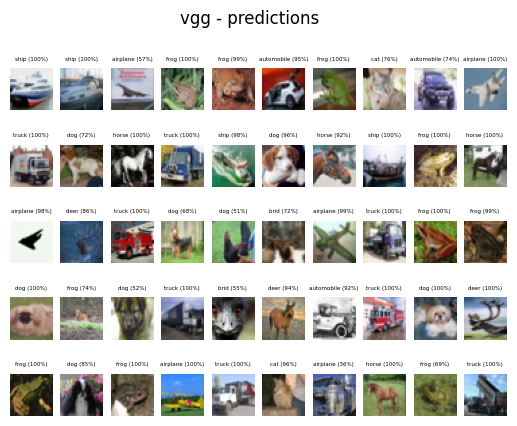

In [19]:
try:
    json_file = open('./class_indices.json', 'r')
    CIFAR_dict = json.load(json_file)
except Exception as e:
    print(e)
    exit(-1)

ROW_IMG = 10
N_ROWS = 5

fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(test_db.data[index])

    with torch.no_grad():
        net.eval()
        logits = net(test_db[index][0].unsqueeze(0).to(DEVICE))
        probs = F.softmax(logits, dim=1)

    title = f'{CIFAR_dict[str(int(torch.argmax(probs)))]} ({torch.max(probs * 100):.0f}%)'

    plt.title(title, fontsize=4)

fig.suptitle('vgg - predictions')


In [ ]:
"""
VGG-16
Mine(batch_size = 32):
After 05 Epoch: 76.2%
After 10 Epoch: 83.1%
After 15 Epoch: 85.5%
After 20 Epoch: 87.3%
structure:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
================================================================
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
         MaxPool2d-7         [-1, 64, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]          73,856
       BatchNorm2d-9        [-1, 128, 112, 112]             256
             ReLU-10        [-1, 128, 112, 112]               0
           Conv2d-11        [-1, 128, 112, 112]         147,584
      BatchNorm2d-12        [-1, 128, 112, 112]             256
             ReLU-13        [-1, 128, 112, 112]               0
        MaxPool2d-14          [-1, 128, 56, 56]               0
           Conv2d-15          [-1, 256, 56, 56]         295,168
      BatchNorm2d-16          [-1, 256, 56, 56]             512
             ReLU-17          [-1, 256, 56, 56]               0
           Conv2d-18          [-1, 256, 56, 56]         590,080
      BatchNorm2d-19          [-1, 256, 56, 56]             512
             ReLU-20          [-1, 256, 56, 56]               0
           Conv2d-21          [-1, 256, 56, 56]         590,080
      BatchNorm2d-22          [-1, 256, 56, 56]             512
             ReLU-23          [-1, 256, 56, 56]               0
        MaxPool2d-24          [-1, 256, 28, 28]               0
           Conv2d-25          [-1, 512, 28, 28]       1,180,160
      BatchNorm2d-26          [-1, 512, 28, 28]           1,024
             ReLU-27          [-1, 512, 28, 28]               0
           Conv2d-28          [-1, 512, 28, 28]       2,359,808
      BatchNorm2d-29          [-1, 512, 28, 28]           1,024
             ReLU-30          [-1, 512, 28, 28]               0
           Conv2d-31          [-1, 512, 28, 28]       2,359,808
      BatchNorm2d-32          [-1, 512, 28, 28]           1,024
             ReLU-33          [-1, 512, 28, 28]               0
        MaxPool2d-34          [-1, 512, 14, 14]               0
           Conv2d-35          [-1, 512, 14, 14]       2,359,808
      BatchNorm2d-36          [-1, 512, 14, 14]           1,024
             ReLU-37          [-1, 512, 14, 14]               0
           Conv2d-38          [-1, 512, 14, 14]       2,359,808
      BatchNorm2d-39          [-1, 512, 14, 14]           1,024
             ReLU-40          [-1, 512, 14, 14]               0
           Conv2d-41          [-1, 512, 14, 14]       2,359,808
      BatchNorm2d-42          [-1, 512, 14, 14]           1,024
             ReLU-43          [-1, 512, 14, 14]               0
        MaxPool2d-44            [-1, 512, 7, 7]               0
          Dropout-45                [-1, 25088]               0
           Linear-46                 [-1, 2048]      51,382,272
             ReLU-47                 [-1, 2048]               0
          Dropout-48                 [-1, 2048]               0
           Linear-49                 [-1, 2048]       4,196,352
             ReLU-50                 [-1, 2048]               0
           Linear-51                   [-1, 10]          20,490
================================================================
Total params: 70,322,250
Trainable params: 70,322,250
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 322.02
Params size (MB): 268.26
Estimated Total Size (MB): 590.86
----------------------------------------------------------------
parameters_count: 70322250
Pytorch(batch_size = 64):
After 05 Epoch: 66.4%
After 10 Epoch: 77.3%
After 15 Epoch: 78.9%
After 20 Epoch: 82.3%
structure:
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (18): ReLU(inplace=True)
    (19): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (20): ReLU(inplace=True)
    (21): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (22): ReLU(inplace=True)
    (23): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (24): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (25): ReLU(inplace=True)
    (26): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (27): ReLU(inplace=True)
    (28): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (29): ReLU(inplace=True)
    (30): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(7, 7))
  (classifier): Sequential(
    (0): Linear(in_features=25088, out_features=4096, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=4096, out_features=4096, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=4096, out_features=1000, bias=True)
  )
)
"""